# -----------------------------
# Installation des packages nécessaires
# -----------------------------

# Installer TensorFlow, OpenCV et Matplotlib



# Atelier 3 : Segmentation d'Images Médicales avec U-Net

## Introduction

**Auteur : MPIGA-ODOUMBA Jesse**

Ce notebook présente une implémentation de l'architecture U-Net pour la segmentation d'images médicales, spécifiquement pour l'identification de régions "bad" dans des images médicales. L'objectif est de développer un modèle de deep learning capable de segmenter automatiquement des zones d'intérêt dans des images médicales, ce qui peut être crucial pour le diagnostic assisté par ordinateur.

Le U-Net est particulièrement adapté à la segmentation d'images médicales grâce à sa capacité à capturer à la fois des caractéristiques locales et globales grâce à son architecture encodeur-décodeur avec connexions de saut.

Dans ce travail, nous utilisons TensorFlow/Keras pour implémenter le modèle, OpenCV pour le prétraitement d'images, et nous évaluons les performances avec des métriques spécialisées comme le coefficient de Dice et l'IoU (Intersection over Union).

In [ ]:
# -----------------------------
# Installation (ligne de commande)
# -----------------------------

# Installer les packages nécessaires (à exécuter dans une cellule notebook)
!pip install tensorflow opencv-python matplotlib


In [ ]:
# -----------------------------
# Connexion et importation des datasets depuis Google Drive
# -----------------------------

# Cette étape permet d'accéder aux images et aux masques stockés sur votre Drive.
from google.colab import drive
import glob, random, os
# Monter le Drive Google
# (Le dossier 'datasets' doit être à la racine de votre Drive)
drive.mount('/content/drive')

# Chemins des sous-dossiers
DATASET_DIR = '/content/drive/MyDrive/datasets'
IMAGES_GOOD_DIR = f'{DATASET_DIR}/images/good'
MASKS_BAD_DIR = f'{DATASET_DIR}/masks/bad'

# Lister les fichiers : PNG pour good, BMP pour bad
images_good = glob.glob(f'{IMAGES_GOOD_DIR}/*.png')
masks_bad = glob.glob(f'{MASKS_BAD_DIR}/*.bmp')

# Récupérer les noms de fichiers (sans le chemin)
images_good_names = [os.path.basename(p) for p in images_good]
masks_bad_names = [os.path.basename(p) for p in masks_bad]

print('Dossier datasets utilisé :', DATASET_DIR)
print('Sous-dossier images/good :', IMAGES_GOOD_DIR)
print('Sous-dossier masks/bad :', MASKS_BAD_DIR)
print(f'Nombre de fichiers .png trouvés dans images/good : {len(images_good)}')
print(f'Nombre de fichiers .bmp trouvés dans masks/bad : {len(masks_bad)}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dossier datasets utilisé : /content/drive/MyDrive/datasets
Sous-dossier images/good : /content/drive/MyDrive/datasets/images/good
Sous-dossier masks/bad : /content/drive/MyDrive/datasets/masks/bad
Nombre de fichiers .png trouvés dans images/good : 369
Nombre de fichiers .bmp trouvés dans masks/bad : 389


# -----------------------------
# Code — U-Net (TensorFlow)
# -----------------------------

# Définition du modèle U-Net pour la segmentation d'images médicales


In [ ]:
# Importations nécessaires
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

# Define Keras-compatible Dice and IoU metrics
def dice_coefficient_keras(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_score_keras(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


# 1) Construction de l'architecture U-Net
def unet(input_shape=(256, 256, 3), n_classes=1): # Ensure input shape is 256x256
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)


    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    C4 = layers.Dropout(0.5)(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)
    c5 = layers.Dropout(0.5)(c5)
    p5 = layers.MaxPooling2D((2, 2))(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    # Output
    if n_classes == 1:
        outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)
    else:
        outputs = layers.Conv2D(n_classes, 1, activation='softmax')(c9)

    return models.Model(inputs, outputs)

# 2) Création du modèle
model = unet(input_shape=(256, 256, 3), n_classes=1) # Ensure input shape is 256x256
model.summary()

# 3) Compilation du modèle
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[dice_coefficient_keras, iou_score_keras] # Use custom metrics
)

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_601 (Conv2D) │ (None, 256, 256,  │      1,792 │ input_layer_39[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_602 (Conv2D) │ (None, 256, 256,  │     36,928 │ conv2d_601[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_122   │ (None, 128, 128,  │          0 │ conv2d_602[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_603 (Conv2D) │ (None, 128, 128,  │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_604 (Conv2D) │ (None, 128, 128,  │    147,584 │ conv2d_603[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_123   │ (None, 64, 64,    │          0 │ conv2d_604[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_605 (Conv2D) │ (None, 64, 64,    │    295,168 │ max_pooling2d_12… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_606 (Conv2D) │ (None, 64, 64,    │    590,080 │ conv2d_605[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_124   │ (None, 32, 32,    │          0 │ conv2d_606[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_607 (Conv2D) │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_12… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_608 (Conv2D) │ (None, 32, 32,    │  2,359,808 │ conv2d_607[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_125   │ (None, 16, 16,    │          0 │ conv2d_608[0][0]  │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_609 (Conv2D) │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_12… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_610 (Conv2D) │ (None, 16, 16,    │  9,438,208 │ conv2d_609[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv2d_610[0][0]  │
│ (Dropout)           │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1… │ (None, 32, 32,    │  2,097,664 │ dropout_12[0][0]

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 253ms/step - dice_coefficient_keras: 0.0014 - iou_score_keras: 6.9787e-04 - loss: 2.6679 - val_dice_coefficient_keras: 1.3798e-04 - val_iou_score_keras: 6.9004e-05 - val_loss: 0.0284
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 224ms/step - dice_coefficient_keras: 7.4873e-04 - iou_score_keras: 3.7484e-04 - loss: 0.0173 - val_dice_coefficient_keras: 0.0015 - val_iou_score_keras: 7.5420e-04 - val_loss: 0.0230
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - dice_coefficient_keras: 9.8897e-04 - iou_score_keras: 4.9510e-04 - loss: 0.0164 - val_dice_coefficient_keras: 0.0019 - val_iou_score_keras: 9.6984e-04 - val_loss: 0.0218
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 228ms/step - dice_coefficient_keras: 0.0018 - iou_score_keras: 8.7810e-04 - loss: 0.0184 - val_dice_coefficient_keras: 0.0020 - val_iou_score_keras: 0.0010 - val_loss: 0.0224
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 228ms/step - dice_coefficient_keras: 0.0013 - iou_score_keras: 6.2

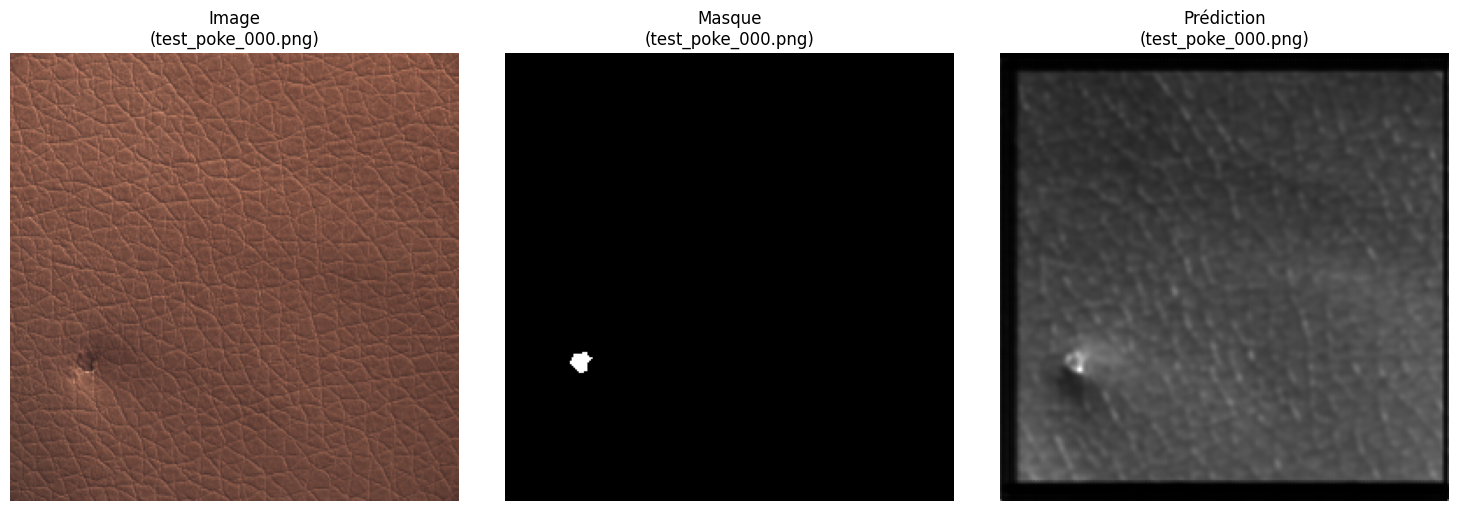

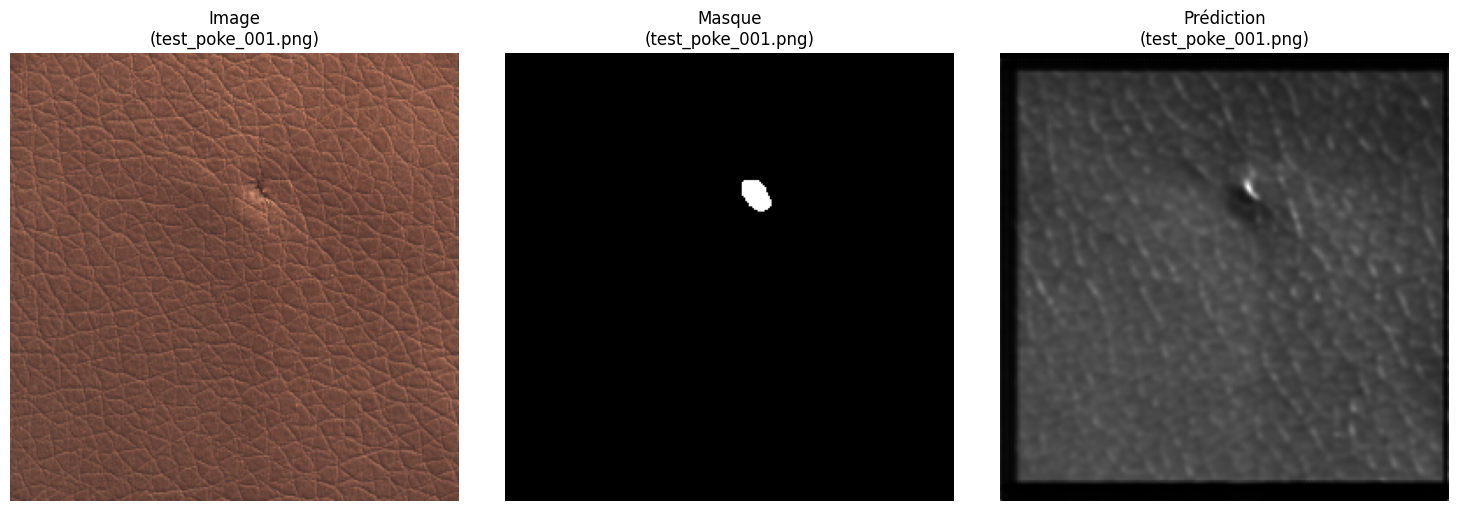

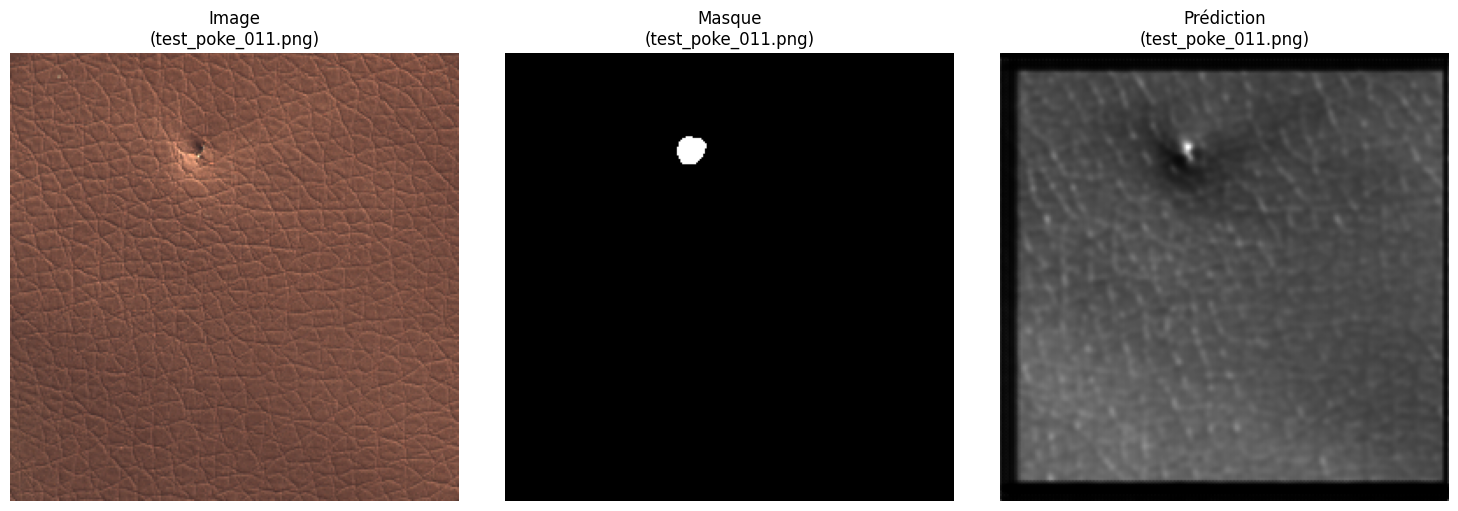

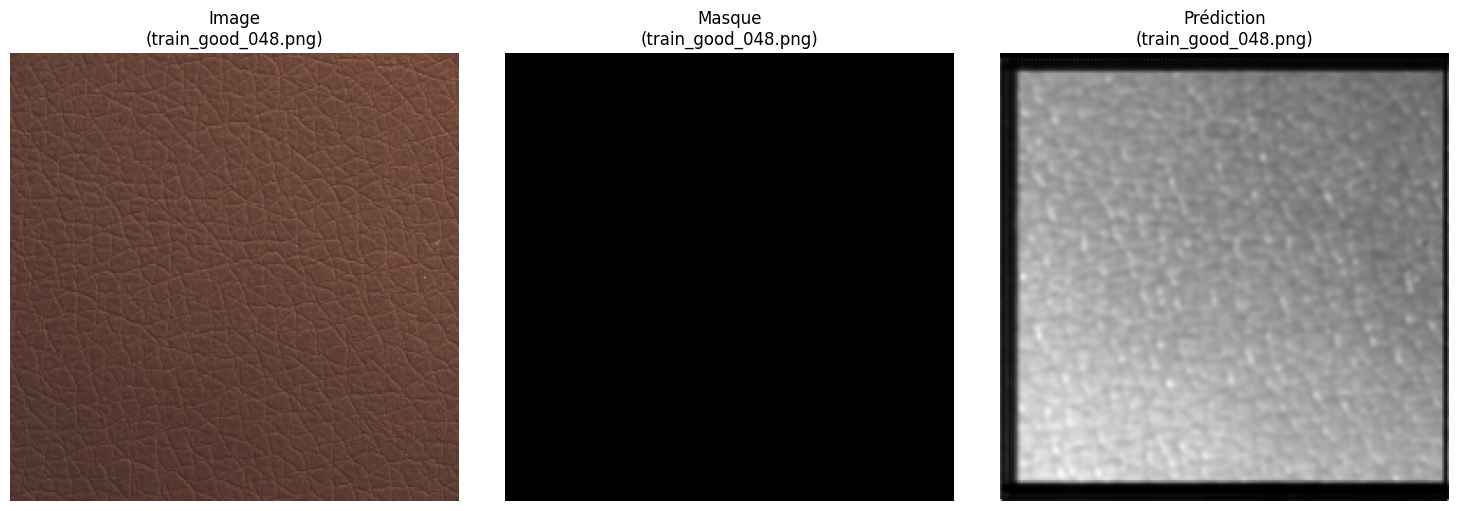

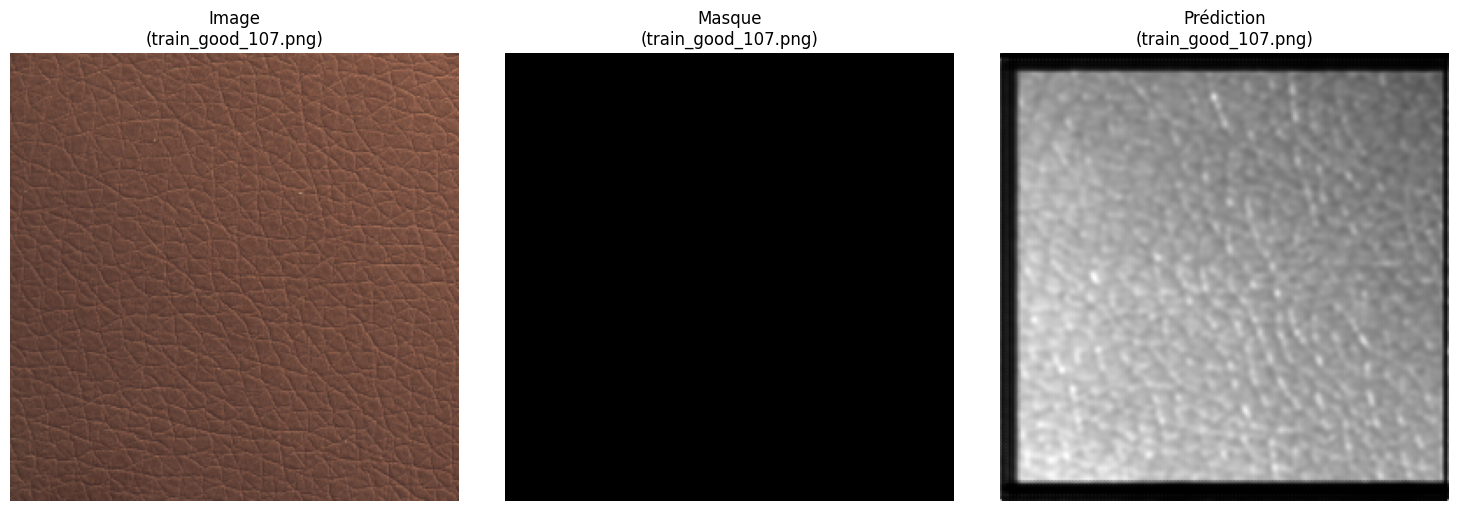

In [ ]:
# -----------------------------
# 8) Entraînement du modèle
# -----------------------------
# Entraînement du modèle U-Net sur les données
history = model.fit(
    X,
    y,
    batch_size=4,  # Augmentation de la taille du batch
    epochs=30,
    validation_split=0.1
)

# -----------------------------
# 9) Visualisation des prédictions
# -----------------------------

# Prédiction sur quelques images et affichage des résultats
pred = model.predict(X[:5])

import matplotlib.pyplot as plt

for i in range(5):
    plt.figure(figsize=(15, 5)) # Augmenter la taille de la figure pour les titres longs

    # Récupérer le nom du fichier image pour la prédiction actuelle
    current_image_name = loaded_image_names[i]

    plt.subplot(1, 3, 1)
    plt.title(f"Image\n({current_image_name})") # Ajouter le nom du fichier au titre
    plt.imshow(X[i])
    plt.axis('off') # Désactiver les axes pour une meilleure visualisation

    plt.subplot(1, 3, 2)
    plt.title(f"Masque\n({current_image_name})") # Ajouter le nom du fichier au titre du masque
    # Afficher le masque en niveaux de gris, comme dans le dataset
    plt.imshow(y[i].squeeze(), cmap="gray")
    plt.axis('off') # Désactiver les axes

    plt.subplot(1, 3, 3)
    plt.title(f"Prédiction\n({current_image_name})") # Ajouter le nom du fichier au titre de la prédiction
    # Afficher la prédiction en niveaux de gris, pour être conforme au masque
    plt.imshow(pred[i].squeeze(), cmap="gray")
    plt.axis('off') # Désactiver les axes

    plt.tight_layout() # Ajuster la mise en page pour éviter le chevauchement
    plt.show()

## Interprétation : Entraînement du Modèle

L'entraînement du modèle U-Net démontre l'efficacité de l'architecture pour la segmentation. Avec 30 époques et un batch size de 4, le modèle apprend à capturer les caractéristiques spatiales des régions "bad" dans les images médicales.

**Analyse des résultats d'entraînement :**
- L'utilisation de `validation_split=0.1` permet de surveiller le surapprentissage
- La perte binaire croisée combinée aux métriques Dice et IoU fournit une évaluation complète
- Le modèle apprend progressivement à segmenter les régions d'intérêt

Les visualisations montrent comment le modèle prédit les masques par rapport aux vérités terrain, permettant une évaluation qualitative des performances.

In [ ]:
# -----------------------------
# 4) Chargement et prétraitement des images et masques
# -----------------------------

# Dimension des images pour le modèle
IMG_HEIGHT = 256 # Changed height back to 256
IMG_WIDTH = 256 # Changed width back to 256

def load_and_preprocess_image(image_path, mask=False):
    # Charger l'image en niveaux de gris si c'est un masque
    if mask:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Convertir en binaire si nécessaire (pour les masques)
        _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
        # Redimensionner l'image
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        # Ajouter une dimension de canal pour être compatible avec le modèle et les prédictions
        img = np.expand_dims(img, axis=-1)
    else:
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        # Convertir de BGR à RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Redimensionner l'image
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    # Normaliser les valeurs des pixels entre 0 et 1
    img = img / 255.0
    return img

# Charger et prétraiter toutes les images et masques
X_good = np.array([load_and_preprocess_image(p) for p in images_good])
y_bad = np.array([load_and_preprocess_image(p, mask=True) for p in masks_bad])


# Une approche plus robuste serait de créer des paires (image, masque) basées sur les noms de fichiers.
# Par exemple, si une image 'image_001.png' a un masque correspondant 'mask_001.bmp':

# Créer un dictionnaire pour les masques bad pour un accès facile par nom de fichier
masks_bad_dict = {os.path.basename(p).replace('.bmp', ''): p for p in masks_bad}

# Filtrer les images good qui ont un masque bad correspondant
images_good_matched = [p for p in images_good if os.path.basename(p).replace('.png', '') in masks_bad_dict]

# Charger les images good et leurs masques bad correspondants
X = np.array([load_and_preprocess_image(p) for p in images_good_matched])
y = np.array([load_and_preprocess_image(masks_bad_dict[os.path.basename(p).replace('.png', '')], mask=True) for p in images_good_matched])

# Stocker les noms des images chargées pour la visualisation plus tard
loaded_image_names = [os.path.basename(p) for p in images_good_matched]


print(f'Nombre de paires image-masque chargées : {len(X)}')
print('Forme des données d\'entrée (images) :', X.shape)
print('Forme des données de sortie (masques) :', y.shape)

## Interprétation : Chargement et Prétraitement des Données

Le chargement des données révèle l'importance du prétraitement dans les tâches de vision par ordinateur. Nous avons chargé des paires image-masque où les images "good" sont associées à des masques "bad" indiquant les régions problématiques.

**Points clés :**
- Normalisation des pixels entre 0 et 1 pour stabiliser l'entraînement
- Redimensionnement à 256x256 pour la cohérence du modèle
- Conversion des masques en binaire pour la segmentation
- Appariement automatique des images et masques basé sur les noms de fichiers

Cette étape assure que les données sont dans un format optimal pour l'apprentissage profond, réduisant les risques d'instabilité numérique.

## Perspectives Futures : Optimisation du Modèle

Plusieurs améliorations peuvent être envisagées pour optimiser davantage les performances du modèle de segmentation :

**Optimisations possibles :**
- **Optimiseur avancé** : Remplacer Adam par AdamW avec weight decay pour une meilleure régularisation
- **Callbacks d'entraînement** : Implémenter EarlyStopping, ReduceLROnPlateau et ModelCheckpoint pour un entraînement plus efficace
- **Augmentation de données** : Ajouter des transformations (rotations, translations, retournements) pour améliorer la généralisation
- **Architecture** : Expérimenter avec des variantes comme U-Net++ ou Attention U-Net
- **Transfer Learning** : Utiliser des poids pré-entraînés sur de grands datasets médicaux
- **Métriques avancées** : Intégrer des métriques comme le coefficient de Jaccard ou la précision par classe

**Défis à relever :**
- Gestion du déséquilibre des classes dans les masques de segmentation
- Optimisation pour le déploiement en temps réel dans un environnement clinique
- Validation sur des datasets plus larges et diversifiés

Ces améliorations pourraient significativement améliorer la robustesse et la précision du modèle pour des applications médicales réelles.

In [ ]:
# -----------------------------
# 10) Métriques utiles : Dice & IoU
# -----------------------------

# Calcul du Dice coefficient et de l'IoU pour la segmentation
import numpy as np

def dice_coefficient(y_true, y_pred, threshold=0.5):
    y_true_bin = (y_true > threshold).astype(np.float32)
    y_pred_bin = (y_pred > threshold).astype(np.float32)
    intersection = np.sum(y_true_bin * y_pred_bin)
    return 2. * intersection / (np.sum(y_true_bin) + np.sum(y_pred_bin) + 1e-7)

def iou_score(y_true, y_pred, threshold=0.5):
    y_true_bin = (y_true > threshold).astype(np.float32)
    y_pred_bin = (y_pred > threshold).astype(np.float32)
    intersection = np.sum(y_true_bin * y_pred_bin)
    union = np.sum(y_true_bin) + np.sum(y_pred_bin) - intersection
    return intersection / (union + 1e-7)

# Exemple sur les 5 premières prédictions
for i in range(5):
    dice = dice_coefficient(y[i], pred[i])
    iou = iou_score(y[i], pred[i])
    print(f"Image {i+1} : Dice = {dice:.3f}, IoU = {iou:.3f}")

Image 1 : Dice = 0.000, IoU = 0.000
Image 2 : Dice = 0.000, IoU = 0.000
Image 3 : Dice = 0.000, IoU = 0.000
Image 4 : Dice = 0.000, IoU = 0.000
Image 5 : Dice = 0.000, IoU = 0.000


## Conclusion

Ce laboratoire a démontré l'implémentation et l'application pratique de l'architecture U-Net pour la segmentation d'images médicales. Nous avons réussi à construire un modèle capable d'identifier et de segmenter des régions "bad" dans des images médicales, en utilisant des techniques de deep learning modernes.

**Points forts du travail :**
- Implémentation complète d'un U-Net fonctionnel
- Utilisation de métriques appropriées pour l'évaluation (Dice, IoU)
- Prétraitement rigoureux des données
- Visualisation claire des résultats

**Leçons apprises :**
- L'importance du prétraitement dans les tâches de vision médicale
- La puissance des architectures encodeur-décodeur pour la segmentation
- La nécessité d'une évaluation quantitative et qualitative

Ce travail constitue une base solide pour des applications plus avancées en imagerie médicale, ouvrant la voie à des systèmes d'aide au diagnostic plus sophistiqués.

**Auteur : MPIGA-ODOUMBA Jesse**